# Importing Libraries

In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
import pickle
import xgboost as xgb
import pyttsx3
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

# Creating a Holistic Model

In [6]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [7]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

# Creating a Styled Draw Landmarks Function

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(27, 3, 87), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(84, 23, 235), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(27, 3, 87), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(84, 23, 235), thickness=2, circle_radius=1)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(27, 3, 87), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(84, 23, 235), thickness=2, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(27, 3, 87), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(84, 23, 235), thickness=2, circle_radius=1)
                             )

# Defining a Function to Extract Key Points

In [9]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Declaring Actions

In [10]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'help', 'more', 'yes', 'phone', 'drink', 'eat', 'i', 'my', 'you', 'what', 'when', 'book', 'know', 'sentence', 'time', 'baby', 'happy', 'sad', 'look', 'fine', 'forget', 'go', 'like'])

# Twenty videos worth of data
no_sequences = 20

# Videos are going to be 30 frames in length
sequence_length = 30

# Loading Pickled Sequences & Labels

In [11]:
with open('sequences.pickle', 'rb') as file2:
    seq=pickle.load(file2)
    
with open('labels.pickle', 'rb') as file2:
    lab=pickle.load(file2)

print(len(seq))
print(len(lab))
print(seq)
print(lab)

500
500
[[array([ 0.51385248,  0.6820749 , -0.72103655, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.56349868,  0.52406609, -0.80139112, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.58225864,  0.49586585, -0.78809148, ...,  0.17178035,
        0.357135  , -0.02734185]), array([ 0.58821881,  0.4845143 , -0.76338375, ...,  0.23165917,
        0.28237194, -0.05219125]), array([ 0.58703744,  0.49053815, -0.77842158, ...,  0.22937514,
        0.28688037, -0.0624429 ]), array([ 0.58894217,  0.4910551 , -0.77411491, ...,  0.30212608,
        0.24861993, -0.05036362]), array([ 0.59451157,  0.484476  , -0.75331497, ...,  0.33949527,
        0.25042081, -0.03746881]), array([ 0.59406477,  0.48579612, -0.75311106, ...,  0.33821562,
        0.25060642, -0.040032  ]), array([ 0.5935235 ,  0.48282227, -0.76843965, ...,  0.39230463,
        0.26982239, -0.03673181]), array([ 0.60174185,  0.48301166, -0.76915979, ...,  0.42615581,
        0.28574187, -0.02892972]), 

# Processing X

In [12]:
# X = np.array(sequences)
X = np.array(seq)

print(X.shape)
print(X)

(500, 30, 1662)
[[[ 0.51385248  0.6820749  -0.72103655 ...  0.          0.
    0.        ]
  [ 0.56349868  0.52406609 -0.80139112 ...  0.          0.
    0.        ]
  [ 0.58225864  0.49586585 -0.78809148 ...  0.17178035  0.357135
   -0.02734185]
  ...
  [ 0.60597503  0.51920646 -0.99688637 ...  0.01239318  0.01695094
   -0.02420695]
  [ 0.60576677  0.51976556 -1.03195345 ...  0.          0.
    0.        ]
  [ 0.60560626  0.52015394 -1.0343039  ...  0.          0.
    0.        ]]

 [[ 0.60489154  0.52025819 -0.91357291 ...  0.11555211  0.07521643
   -0.02562112]
  [ 0.56649119  0.52461588 -0.89607811 ...  0.07370465  0.06537435
   -0.06727287]
  [ 0.55389428  0.52758002 -0.90259761 ...  0.07368654  0.06840274
   -0.05703885]
  ...
  [ 0.54901022  0.53358477 -0.87631482 ...  0.19256523  0.1305238
   -0.04302783]
  [ 0.54903805  0.53384423 -0.86699218 ...  0.22121443  0.15424718
   -0.0481738 ]
  [ 0.54737878  0.53324538 -0.86292303 ...  0.29798457  0.22786197
   -0.03691287]]

 [[ 0.5

# Processing Y

In [13]:
# y = to_categorical(labels).astype(int)
# y = to_categorical(lab).astype(int)

y = lab
# Encode labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y.shape)
print(y)

(500,)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 16 16 16 16 16 16 1

# Defining LSTM Model

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=7)

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(LSTM(64, activation='relu'))
model_lstm.add(Dense(actions.shape[0], activation='softmax'))  # Output layer with the number of classes

# Loading Previously Trained LSTM Model Weights

In [15]:
model_lstm.load_weights('lstm_model.h5')

# Compiling Model

In [16]:
# Compile the model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           916992    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
Total params: 968025 (3.69 MB)
Trainable params: 968025 (3.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Evaluating Model

In [18]:
# Evaluate the model - Accuracy
accuracy_lstm = model_lstm.evaluate(X_test, y_test)[1]
print(f"Accuracy of LSTM (Method 1): {accuracy_lstm}")

# Make predictions
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model - Accuracy
accuracy_lstm2 = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy of LSTM (Method 2): {accuracy_lstm2}")

# Evaluate the model - MultiLabel Confusion Matrix
print(multilabel_confusion_matrix(y_test, y_pred_classes))

1/1 [==============================] - 1s 748ms/step - loss: 0.4863 - accuracy: 0.8400
Accuracy of LSTM (Method 1): 0.8399999737739563
1/1 [==============================] - 0s 362ms/step
Accuracy of LSTM (Method 2): 0.84
[[[24  0]
  [ 0  1]]

 [[24  0]
  [ 0  1]]

 [[24  1]
  [ 0  0]]

 [[24  0]
  [ 0  1]]

 [[22  1]
  [ 0  2]]

 [[24  0]
  [ 0  1]]

 [[24  0]
  [ 0  1]]

 [[23  0]
  [ 1  1]]

 [[23  0]
  [ 1  1]]

 [[24  0]
  [ 0  1]]

 [[24  1]
  [ 0  0]]

 [[24  0]
  [ 1  0]]

 [[22  1]
  [ 0  2]]

 [[24  0]
  [ 1  0]]

 [[24  0]
  [ 0  1]]

 [[23  0]
  [ 0  2]]

 [[24  0]
  [ 0  1]]

 [[22  0]
  [ 0  3]]

 [[23  0]
  [ 0  2]]]


IndexError: index 19 is out of bounds for axis 0 with size 19

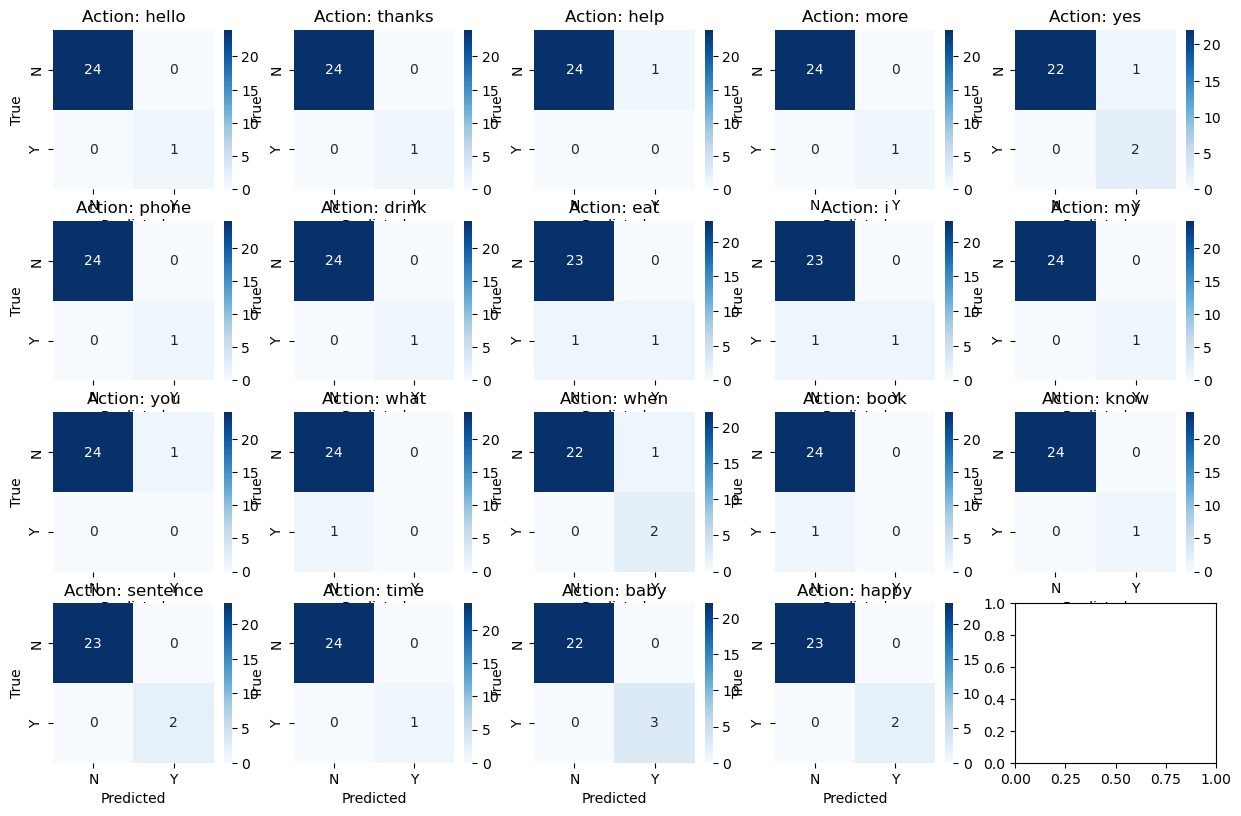

In [30]:
# Evaluate the model - MultiLabel Confusion Matrix
confusion_matrix_lstm = multilabel_confusion_matrix(y_test, y_pred_classes)

# Plot and visualize the confusion matrix
def plot_multilabel_confusion_matrix(confusion_matrix, labels):
    num_labels = len(labels)
    num_subplots = min(num_labels, 25)  # Limit to 25 subplots for visualization

    plt.figure(figsize=(15, 12))
    for i in range(num_subplots):
        plt.subplot(5, 5, i + 1)
        sns.heatmap(confusion_matrix[i], annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
        plt.title(f'Action: {labels[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.tight_layout()
    plt.show()

plot_multilabel_confusion_matrix(confusion_matrix_lstm, actions)

In [19]:
res = model_lstm.predict(X_test)
# print(res)
print(len(res))
print(res.shape)

1/1 [==============================] - 0s 46ms/step
25
(25, 25)


In [17]:
colors = [(33,12,105)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[prob], (0, 85+num*40), cv2.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

# Defining a Function to Convert Predictions to Speech

In [18]:
# Initialize the text-to-speech engine
engine = pyttsx3.init()

# Function to convert text to speech
def text_to_speech(text):
    engine.say(text)
    engine.runAndWait()

# text_to_speech("Your text to convert into speech")

# Real Time Sign Language Translator

In [19]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8
previous_action = None

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        # sequence.insert(0,keypoints)
        # sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model_lstm.predict(np.expand_dims(sequence, axis=0))[0]
            # print(actions[np.argmax(res)])
            # text_to_speech(actions[np.argmax(res)])
            predicted_action = actions[np.argmax(res)]
            print(predicted_action)

            # Check if the recognized action is different from the previous one
            if predicted_action != previous_action:
                text_to_speech(predicted_action)
                previous_action = predicted_action
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            # image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (8, 8, 99), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Prediction Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step
hello
1/1 [==============================] - 0s 26ms/step
hello
1/1 [==============================] - 0s 25ms/step
hello
1/1 [==============================] - 0s 27ms/step
hello
1/1 [==============================] - 0s 26ms/step
hello
1/1 [==============================] - 0s 26ms/step
hello
1/1 [==============================] - 0s 27ms/step
hello
1/1 [==============================] - 0s 27ms/step
hello
1/1 [==============================] - 0s 25ms/step
hello
1/1 [==============================] - 0s 24ms/step
hello
1/1 [==============================] - 0s 26ms/step
hello
1/1 [==============================] - 0s 24ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 25ms/step
hello
1/1 [==============================] - 0s 24ms/step
hello
1/1 [==============================] - 0s 24ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [=========